## Main Challenge

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

*Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.*

<a href="https://www.kaggle.com/c/nlp-getting-started/overview" >Kaggle Competition</a>

### Libraries

In [23]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import nltk
import wordcloud
import numpy as np
import re

In [2]:
print("sklearn: {}".format(sklearn.__version__))
print("pandas: {}".format(pd.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("nltk: {}".format(nltk.__version__))
print("wordcloud: {}".format(wordcloud.__version__))
print("numpy: {}".format(np.__version__))

sklearn: 0.23.2
pandas: 1.1.4
seaborn: 0.11.0
matplotlib: 3.3.3
nltk: 3.5
wordcloud: 1.8.1
numpy: 1.19.4


### Data

In [3]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

### Exploratory Data Analysis

In [4]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (7613, 5)
test shape: (3263, 4)


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


According with documentation:

* **text**: The text of a tweet
* **keyword**: A keyword from that tweet (although this may be blank!)
* **location**: The location the tweet was sent from (may also be blank)

In [9]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
train["keyword"].value_counts().head(10)

fatalities     45
armageddon     42
deluge         42
harm           41
body%20bags    41
sinking        41
damage         41
evacuate       40
twister        40
siren          40
Name: keyword, dtype: int64

In [11]:
train["location"].value_counts().head(10)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

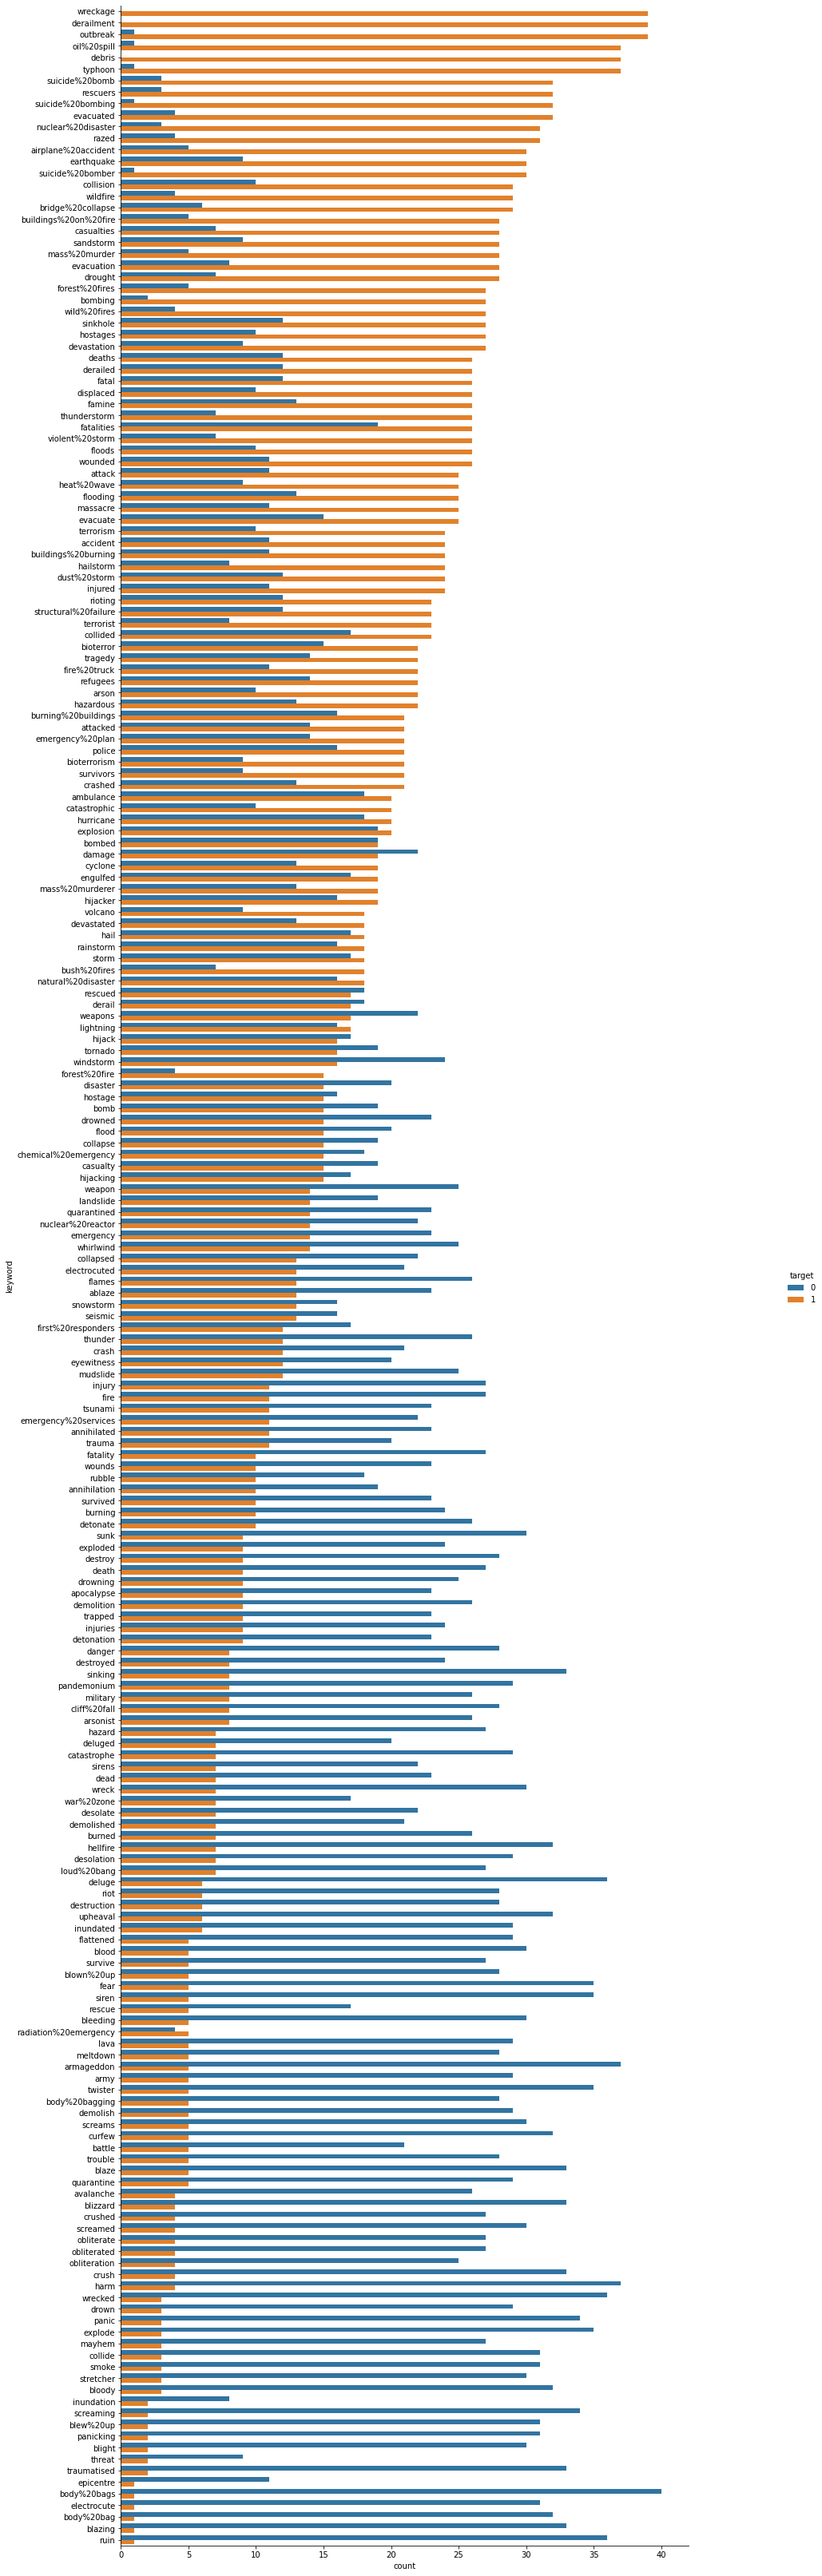

In [12]:
keywords_order = train[train["target"] == 1].groupby(["keyword"]).count()["target"].sort_values(ascending=False).keys()

g = sns.catplot(y="keyword", hue="target", data=train, kind="count", order=keywords_order)
g.fig.set_size_inches(20,50)

Few observations:

* location needs a pre process to make cities more generic
* keywords has special characters like %20 that needs to be removed, also apply stemming

In [13]:
df_train = train.copy()
df_test = test.copy()

In [14]:
stemmer = nltk.stem.porter.PorterStemmer()

In [15]:
df_train["keyword"] = df_train["keyword"].apply(lambda x: str(x).replace("%20", " "))
df_train["keyword_stemmer"] = df_train["keyword"].apply(lambda x: stemmer.stem(str(x)))

In [16]:
print("Original keyword length: {}".format(df_train["keyword"].unique().size))
print("Stemmer keyword length: {}".format(df_train["keyword_stemmer"].unique().size))

Original keyword length: 222
Stemmer keyword length: 167


In [17]:
df_train["location_split"] = df_train["location"].apply(lambda x: str(x).replace(" ", "").split(",")[-1])
df_train["location_split"].value_counts().head(20)

nan             2533
USA              222
CA               126
NewYork           81
UK                66
Canada            65
UnitedStates      59
London            58
NY                56
England           53
TX                52
Nigeria           51
Australia         45
FL                43
NC                39
India             39
IL                37
California        37
Texas             32
GA                29
Name: location_split, dtype: int64

In [18]:
print("Original location length: {}".format(df_train["location"].unique().size))
print("Split location length: {}".format(df_train["location_split"].unique().size))

Original location length: 3342
Split location length: 2321


### Feature Engineer & Train/Test distribution

In [32]:
# Word Count
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["word_count"] = df_test["text"].apply(lambda x: len(x.split()))

# Special Character Count
df_train["special_character_count"] = df_train["text"].apply(lambda x: len([value for value in x if re.sub("[A-Za-z0-9.,']+", "", value)]))
df_test["special_character_count"] = df_test["text"].apply(lambda x: len([value for value in x if re.sub("[A-Za-z0-9.,']+", "", value)]))

# Hashtag Count
df_train["hashtag_count"] = df_train["text"].apply(lambda x: x.count("#"))
df_test["hashtag_count"] = df_test["text"].apply(lambda x: x.count("#"))

# Have URL
df_train["url"] = df_train["text"].apply(lambda x: 1 if "http" in x or "www" in x else 0)
df_test["url"] = df_test["text"].apply(lambda x: 1 if "http" in x or "www" in x else 0)

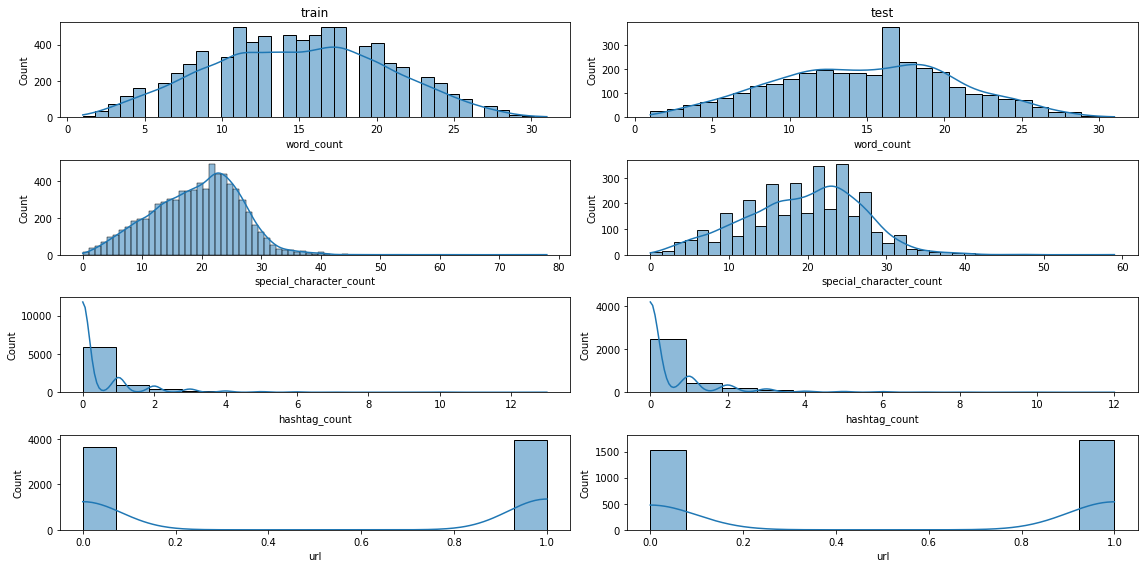

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

sns.histplot(data=df_train, x="word_count", kde=True, ax=axes[0][0])
sns.histplot(data=df_test, x="word_count", kde=True, ax=axes[0][1])

sns.histplot(data=df_train, x="special_character_count", kde=True, ax=axes[1][0])
sns.histplot(data=df_test, x="special_character_count", kde=True, ax=axes[1][1])

sns.histplot(data=df_train, x="hashtag_count", kde=True, ax=axes[2][0])
sns.histplot(data=df_test, x="hashtag_count", kde=True, ax=axes[2][1])

sns.histplot(data=df_train, x="url", kde=True, ax=axes[3][0])
sns.histplot(data=df_test, x="url", kde=True, ax=axes[3][1])

for ax, col in zip(axes[0], ["train", "test"]):
    ax.set_title(col)

fig.tight_layout()

### GloVe Tests

In [34]:
from sklearn.manifold import TSNE

In [35]:
embeddings = {}
with open("dataset/glove.6B.50d.txt", "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], "float32")
        embeddings[word] = vector

In [36]:
tsne = TSNE(n_components=2, random_state=0)

In [37]:
words = list(embeddings.keys())
vectors = [embeddings[word] for word in words]

In [38]:
glove_df = pd.DataFrame(vectors, index=words)

In [39]:
glove_df = sklearn.utils.shuffle(glove_df)
glove_df = glove_df.head(200)

In [40]:
%%time

X = tsne.fit_transform(glove_df)

Wall time: 2.06 s


In [41]:
x = X[:, 0]
y = X[:, 1]

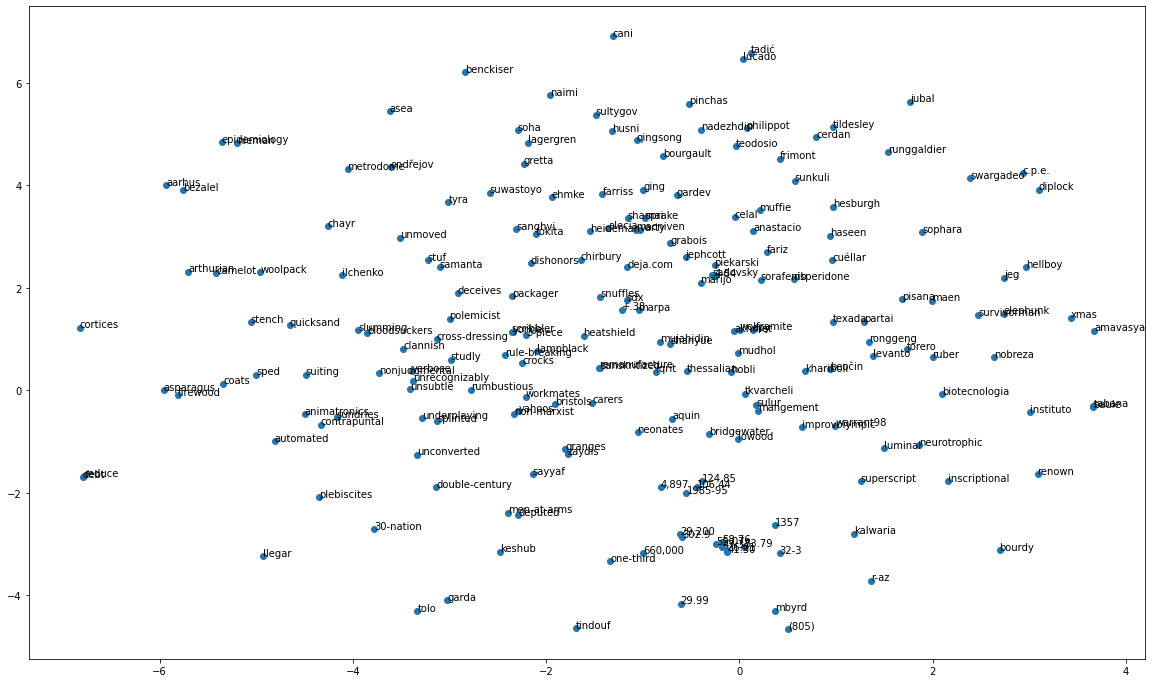

In [42]:
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter(x, y)

for i, txt in enumerate(glove_df.index):
    ax.annotate(txt, (x[i], y[i]))
    
plt.show()